<a href="https://colab.research.google.com/github/julia-lina-tan/rl-policy-fusion/blob/main/rl_policy_fusion_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

This notebook trains agents from Stable Baselines3 in the "Reacher" Gym environment.

1. An agent will be trained to reach for rewards in the 1st quadrant of the workspace
2. An agent will be trained to reach for rewards in the 2nd quadrant of the workspace
3. A fused agent will be initialised from these two previous agents using OT techniques
4. The fused agent will relearn to reach for rewards in both the 1st and 2nd quadrants of the workspace
5. The effectiveness of initialising via fusion (as compared to relearning from the original models or creating a new model from scratch) will be evaluated

# Setup

Install Stable Baselines and other dependencies.

In [1]:
!pip install stable-baselines3[extra]
!apt install swig cmake
!pip install stable-baselines3[extra] box2d box2d-kengz

     |████████████████████████████████| 153kB 4.1MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 2s (464 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 160706 files and directories currently installed.)
Prepar

In [2]:
# Additional installations/imports for rendering Gym environment

!apt-get install -y xvfb x11-utils
!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.* 
!apt-get install imagemagick

import pyvirtualdisplay
_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 994 kB of archives.
After this operation, 2,981 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9 [784 kB]
Fetched 994 kB in 2s (471 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 161497 files 

Import RL policy, RL agents and wrappers.

In [14]:
import gym
import numpy as np
import torch as pt
import matplotlib.pyplot as plt

from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor

Install [pybullet-gym](https://github.com/benelot/pybullet-gym) and import Reacher environment.

In [14]:
!git clone https://github.com/openai/gym.git
!cd gym && pip install -e .

Obtaining file:///content/gym
  Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3
  Running setup.py develop for gym


In [15]:
!git clone https://github.com/benelot/pybullet-gym.git
!cd pybullet-gym && pip install -e .

Obtaining file:///content/pybullet-gym
     |████████████████████████████████| 79.0MB 46kB/s 
  Created wheel for pybullet: filename=pybullet-3.1.7-cp37-cp37m-linux_x86_64.whl size=89750747 sha256=59ea204f16024f0f7f66d38fd1b893361244069816263de6e12b7a89dbf00acd
  Stored in directory: /root/.cache/pip/wheels/30/56/e6/fce8276a2f30165f7ac31089bb72f390fa16b87328651e1a5a
Successfully built pybullet
  Running setup.py develop for pybulletgym


In [6]:
import gym  # open ai gym
import pybulletgym  # register PyBullet enviroments with open ai gym

env = gym.make('ReacherPyBulletEnv-v0')
# env.render() # call this before env.reset, if you want a window showing the environment
env.reset()  # should return a state vector if everything worked

/content/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


array([-0.13500774,  0.18494701,  0.23729103, -0.0573396 ,  0.98425564,
        0.17675075,  0.        ,  0.45267823,  0.        ])

## Rendering agent in environment

In [11]:
import cv2
from google.colab.patches import cv2_imshow
from matplotlib import animation

def save_frames_as_gif(frames, path='../content/', filename='gym_animation.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=60)

def render_agent_in_env(agent, env, n_eval_episodes=5, path='../content/', filename='gym_animation'):
    for i in range(n_eval_episodes):
      frames = []
      obs = env.reset()
      for t in range(500):

          #Render to frames buffer
          frame = np.array(env.render('rgb_array'))
          cv2.putText(frame, text=f'Episode {i+1}', org=(50,50), fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=0.8, color=(0,0,0))
          frames.append(frame)
          action, _states = model.predict(obs)
          obs, rewards, done, info = env.step(action)
          if done:
            break
      save_frames_as_gif(frames, path=path, filename=f'{filename}-ep{i+1}.gif')

# Train the agent

In [10]:
env = Monitor(env)
model = PPO('MlpPolicy', env, verbose=1, seed=1)

Using cpu device
Wrapping the env in a DummyVecEnv.


# Test the agent

In [15]:
from stable_baselines3.common.evaluation import evaluate_policy

def plot_rewards(mean_reward, title=None):
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.xlabel('Episodes')
    plt.ylabel('Rewards at episode')
    plt.xticks(list(range(1, len(mean_reward)+1)))
    plt.plot(list(range(1, len(mean_reward)+1)), mean_reward, marker='o')
    plt.show()

mean reward=-0.65 +/- 3.48


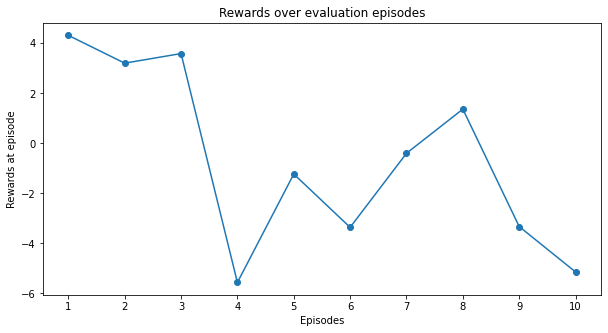

In [16]:
ep_rewards, ep_steps = evaluate_policy(model, env, n_eval_episodes=10, deterministic=True, return_episode_rewards=True)

print(f'mean reward={(sum(ep_rewards)/len(ep_rewards)):.2f} +/- {np.std(ep_rewards):.2f}')
plot_rewards(ep_rewards, title='Rewards over evaluation episodes')

KeyboardInterrupt: ignored

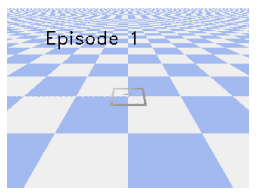

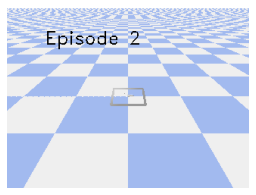

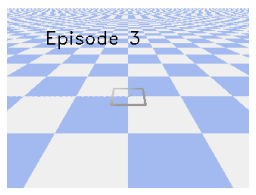

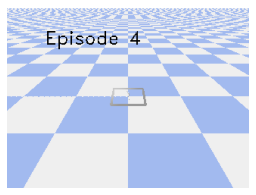

In [18]:
os.makedirs('../content/agent1', exist_ok=True)
render_agent_in_env(model, env, n_eval_episodes=10, path='../content/agent1', filename='test')